# LSTM
LSTM 130. Coding 1-2K. Non-Gudenas. Max RCI.

Acc 76%, Prec 77%, Recall 98%, F1 86%.

In [19]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 15:40:51.751714
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [20]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [21]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [22]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [23]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1,7]
for c in EXCLUSIONS:
    print('Exclude cell line',c,all_cell_lines[c])

Exclude cell line 1 H1.hESC
Exclude cell line 7 NCI.H460


## Data Load

In [24]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,exclusions=[]):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_max = None
                    rci_count = 0
                    cell_line = 0 # first line is 0 = A549
                    for rci_str in fields:
                        if rci_str != "nan" and cell_line not in exclusions:
                            rci_val = float(rci_str)
                            if rci_max is None or rci_val > rci_max:
                                rci_max = rci_val
                            rci_count += 1
                        cell_line += 1   
                    if rci_count > 0:
                        gene_to_rci[gene_id] = rci_max
                        overall_sum += rci_max
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [25]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 15:40:53.416213
Load RCI values...
Number of RCI values 13512
Mean RCI value 0.742330935725574
Num RCI: 13512
Example RCI: [('ENSG00000000003', 2.29436), ('ENSG00000000419', 2.1946), ('ENSG00000000457', 0.434284)]
Load genes...
2023-01-17 15:40:53.499819
Load sequence...
2023-01-17 15:41:04.107746
Num IDs: 13675
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 10438 ones out of 13675 labels.
Num labels: 13675
Example labels: [0, 0, 1, 0]
Num sequences: 13675
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 167,

## Model

In [26]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [27]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 15:41:04.140204
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1997, 4)           1028      
                                                                 
 bidirectional_6 (Bidirectio  (None, 1997, 64)         9472      
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 1997, 16)         1040      
 tributed)                                                       
                                                                 
 flatten_6 (Flatten)         (None, 31952)             0         
                                                                 
 dropout_6 (Dropout)         (None, 31952)             0         
                                                                 
 dense_13 (Dense)  

## Training

In [28]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 15:41:05.013542
2023-01-17 15:41:05.014196
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10877, 1997) (10877, 1)
Valid sizes (2798, 1997) (2798, 1)
Train set ones/size 8240 / 10877
Valid set ones/size 2198 / 2798
BUILD MODEL
COMPILE
FIT
2023-01-17 15:41:07.123508
Epoch 1/3
340/340 [==============================] - 44s 122ms/step - loss: 0.5358 - accuracy: 0.7557 - val_loss: 0.4887 - val_accuracy: 0.7848
Epoch 2/3
340/340 [==============================] - 40s 117ms/step - loss: 0.5148 - accuracy: 0.7614 - val_loss: 0.4863 - val_accuracy: 0.7852
Epoch 3/3
340/340 [==============================] - 41s 121ms/step - loss: 0.4921 - accuracy: 0.7715 - val_loss: 0.4984 - val_accuracy: 0.7802


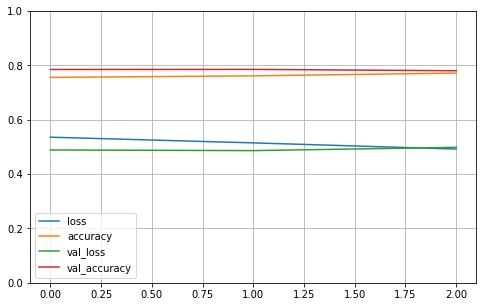

Compute valiation accuracy
2023-01-17 15:43:32.058576
Range of scores: 0.2741134 to 0.98230183
Predicted zeros and ones 85 2713
Accuracy: 78.02% Precision: 79.17% Recall: 97.73% F1: 87.48%
2023-01-17 15:43:37.826662
Fold 2
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10965, 1997) (10965, 1)
Valid sizes (2710, 1997) (2710, 1)
Train set ones/size 8383 / 10965
Valid set ones/size 2055 / 2710
BUILD MODEL
COMPILE
FIT
2023-01-17 15:43:40.248993
Epoch 1/3
343/343 [==============================] - 44s 119ms/step - loss: 0.5275 - accuracy: 0.7652 - val_loss: 0.5135 - val_accuracy: 0.7590
Epoch 2/3
343/343 [==============================] - 40s 117ms/step - loss: 0.5071 - accuracy: 0.7682 - val_loss: 0.5156 - val_accuracy: 0.7565
Epoch 3/3
343/343 [==============================] - 40s 117ms/step - loss: 0.4855 - accuracy: 0.7769 - val_loss: 0.5346 - val_accuracy: 0.7583


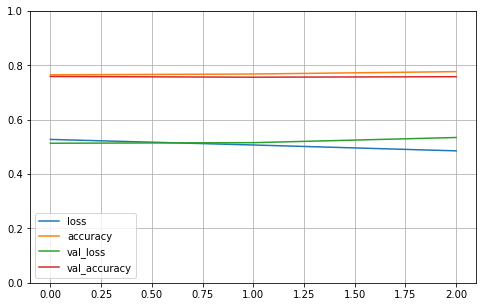

Compute valiation accuracy
2023-01-17 15:45:44.832278
Range of scores: 0.1514158 to 0.9941414
Predicted zeros and ones 68 2642
Accuracy: 75.83% Precision: 76.50% Recall: 98.35% F1: 86.05%
2023-01-17 15:45:49.629591
Fold 3
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10977, 1997) (10977, 1)
Valid sizes (2698, 1997) (2698, 1)
Train set ones/size 8391 / 10977
Valid set ones/size 2047 / 2698
BUILD MODEL
COMPILE
FIT
2023-01-17 15:45:51.675075
Epoch 1/3
344/344 [==============================] - 45s 120ms/step - loss: 0.5267 - accuracy: 0.7633 - val_loss: 0.5404 - val_accuracy: 0.7569
Epoch 2/3
344/344 [==============================] - 41s 118ms/step - loss: 0.5036 - accuracy: 0.7690 - val_loss: 0.5281 - val_accuracy: 0.7550
Epoch 3/3
344/344 [==============================] - 41s 119ms/step - loss: 0.4854 - accuracy: 0.7764 - val_loss: 0.5643 - val_accuracy: 0.7528


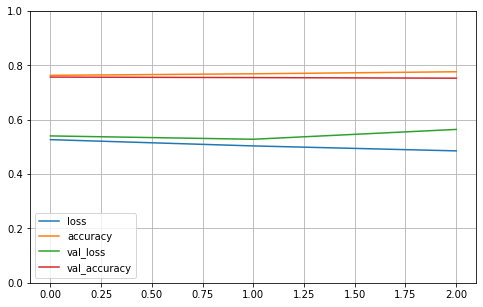

Compute valiation accuracy
2023-01-17 15:48:17.217960
Range of scores: 0.13942368 to 0.99365956
Predicted zeros and ones 56 2642
Accuracy: 75.28% Precision: 76.12% Recall: 98.24% F1: 85.78%
2023-01-17 15:48:23.001335
Fold 4
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10875, 1997) (10875, 1)
Valid sizes (2800, 1997) (2800, 1)
Train set ones/size 8323 / 10875
Valid set ones/size 2115 / 2800
BUILD MODEL
COMPILE
FIT
2023-01-17 15:48:25.078692
Epoch 1/3
340/340 [==============================] - 45s 124ms/step - loss: 0.5248 - accuracy: 0.7631 - val_loss: 0.5364 - val_accuracy: 0.7486
Epoch 2/3
340/340 [==============================] - 40s 119ms/step - loss: 0.5019 - accuracy: 0.7650 - val_loss: 0.5426 - val_accuracy: 0.7504
Epoch 3/3
340/340 [==============================] - 40s 119ms/step - loss: 0.4850 - accuracy: 0.7749 - val_loss: 0.5512 - val_accuracy: 0.7479


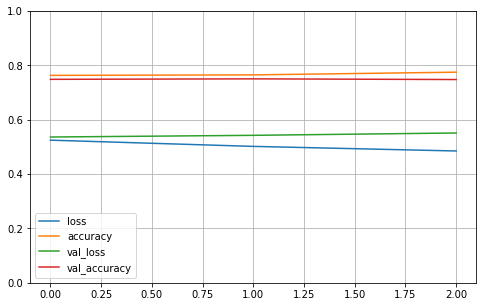

Compute valiation accuracy
2023-01-17 15:50:31.091573
Range of scores: 0.1759471 to 0.9905466
Predicted zeros and ones 147 2653
Accuracy: 74.79% Precision: 76.55% Recall: 96.03% F1: 85.19%
2023-01-17 15:50:36.037228
Fold 5
Training example
[187 235 170 ...   0   0   0]
Train sizes (11006, 1997) (11006, 1)
Valid sizes (2669, 1997) (2669, 1)
Train set ones/size 8415 / 11006
Valid set ones/size 2023 / 2669
BUILD MODEL
COMPILE
FIT
2023-01-17 15:50:38.126326
Epoch 1/3
344/344 [==============================] - 44s 118ms/step - loss: 0.5278 - accuracy: 0.7634 - val_loss: 0.5173 - val_accuracy: 0.7598
Epoch 2/3
344/344 [==============================] - 40s 116ms/step - loss: 0.5063 - accuracy: 0.7662 - val_loss: 0.5225 - val_accuracy: 0.7610
Epoch 3/3
344/344 [==============================] - 40s 115ms/step - loss: 0.4840 - accuracy: 0.7733 - val_loss: 0.5440 - val_accuracy: 0.7598


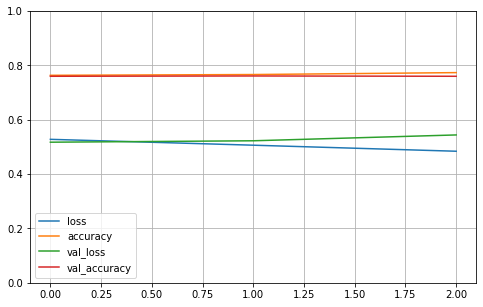

Compute valiation accuracy
2023-01-17 15:52:42.054222
Range of scores: 0.21879776 to 0.9914254
Predicted zeros and ones 61 2608
Accuracy: 75.98% Precision: 76.50% Recall: 98.62% F1: 86.16%
2023-01-17 15:52:47.850225

Cross validation 5 folds 3 epochs
 accuracy mean 75.98% +/- 1.10
 precision mean 76.97% +/- 1.11
 recall mean 97.79% +/- 0.93
 F1 mean 86.13% +/- 0.75
2023-01-17 15:52:47.852759


In [29]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())